# Step 4: Monthly Modeling 
In this notebook, we create predictive models to figure out 

In [1]:
# Import defaultdict
from collections import defaultdict

# Import calendar for month names
import calendar

# Numpy and pandas for manipulating the data
import numpy as np
import pandas as pd

# Matplotlib and seaborn for visualization
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# GridSearchCV for training 
from sklearn.model_selection import GridSearchCV

# Performance metrics from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Prophet for time forecasting
from fbprophet import Prophet

# Classification models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


# To hide stdout because Prophet can be loud
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [2]:
feature_file = './data/cleaned/feature.csv'
by_date_total_file = './data/cleaned/by_date_total.csv'
provisions_file = './data/raw/provisions.csv'
useful_provisions_file = './data/cleaned/useful_provisions.csv'

feature_df = pd.read_csv(feature_file, parse_dates=True, index_col=0)
by_date_total_df = pd.read_csv(by_date_total_file, parse_dates=True, index_col=0)
provisions_df = pd.read_csv(provisions_file, parse_dates=True)
useful_provisions_df = pd.read_csv(useful_provisions_file, parse_dates=True, index_col=0)

In [3]:
# Styling
# make figures bigger
mpl.rcParams['figure.figsize'] = 12, 8

# change grid line styling
mpl.rcParams['grid.color'] = '#d6dbdf'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.linewidth'] = 0.5

# change font
mpl.rcParams['font.family'] = 'Open Sans'

## Fixing up features
There are still a couple of features to be tweaked. Although the data was cleaned in `clean-data` journal, it is more convenient to add the provisions features here, as they are likely to be changed along with changes to the model.

In [4]:
# Add only the useful provisions to our feature_df (k from this year and k from n years prior)
def add_provisions(feature_df, provisions_df, useful_provisions_df, k=30, n=5):
    # Get the state and year columns for a join later and lawtotal to account for excluded provisions
    columns = list(useful_provisions_df.head(k)['provision'].values)
    columns.extend(['year', 'state', 'lawtotal'])     
    
    # Get the years 
    years = feature_df.groupby('this_year').count().index.values

    # Keep track of provisions for this year and n years prior
    current_provisions = []
    old_provisions = []

    # Add the provisions from each year to a list
    for year in years:
        current_provisions.append(provisions_df[provisions_df['year'] == year][columns])
        old_provisions.append(provisions_df[provisions_df['year'] == year - n][columns])

    # Put the provisions into a DataFrame
    current_provisions = pd.concat(current_provisions)
    old_provisions = pd.concat(old_provisions)
    old_provisions['year'] += n # Match the year which we want to join onto

    # Merge the provisions
    all_provisions = pd.merge(current_provisions, old_provisions, 
                              on=['state', 'year'], suffixes=('', '_old'))

    # Add provisions to feature_df and return the new feature_df
    feature_df = pd.merge(feature_df, all_provisions, 
                          left_on=['this_year', 'state'], 
                          right_on=['year', 'state'])
    return feature_df.drop('year', axis=1)

In [5]:
# Include provision information
feature_df = add_provisions(feature_df, provisions_df, useful_provisions_df, k=10, n=5)

# Exclude states that have a low average number of deaths. In this case, we choose 2 as our threshold
min_deaths = 2
average_deaths = feature_df.groupby('state')['next_deaths'].mean()
excluded = average_deaths[average_deaths < min_deaths].index
states = average_deaths[average_deaths >= min_deaths].index

# Filter out the states
feature_df = feature_df[~feature_df['state'].isin(excluded)]

# Add the label. The label is whether gun violence will increase by more than 20% for a given month
feature_df['label'] = (feature_df['rate_change'] > 0.2).astype(int)

# Sort the data chronologically by date, then alphabetically by state name  
feature_df = feature_df.sort_values(['next_date', 'state']).reset_index().drop('index', axis=1)

# Drop columns regarding year 
# feature_df = feature_df.drop(['next_year', 'this_year'], axis=1)

# Add dummies for months
feature_df = pd.get_dummies(feature_df, columns=['month'])

# By dropping null values, we lose the first month as there is no previous date for the first month
feature_df = feature_df.dropna()

# Make placeholders for two more features: one for predictions of this month, and one for next month
feature_df['this_preds'] = 0
feature_df['next_preds'] = 0

# Finally, make a weekly DataFrame for the time series predictions
resampled_df = by_date_total_df.resample('W').sum()

***
## Modeling
Now that all the `feature_df` is ready with all of the features and information, it's time to model the data. Here is an image of the pipeline:

We define some functions to modularize parts of the pipeline.

In [6]:
# First, define need a function to easily get time series predictions
def get_trend_predictions(resampled_df, date, state, n_periods=14):
    time_series = resampled_df[:date][state]
    time_series = time_series.reset_index()
    time_series.columns = ['ds', 'y']

    # Model the data and make predictions
    model = Prophet(yearly_seasonality=True)
    model = model.fit(time_series)
    future = model.make_future_dataframe(periods=n_periods)
    output = model.predict(future)[['ds', 'yhat']]

    # Resample monthly and add the state as a column
    output = output.set_index('ds').resample('M').sum()

    # Get predictions for this month and next month
    this_output = output[:date].reset_index()
    this_output.columns = ['this_date', 'this_preds']
    next_output = output.reset_index().shift(-1).dropna()
    next_output.columns = ['next_date', 'next_preds']

    return this_output, next_output

# Update trend predictions up to the current observation's state
def update_trends(feature_df, resampled_df, this_date, states): 
    for state in states:
        # Update trend predictions for this state
        this_trend_preds, next_trend_preds = get_trend_predictions(resampled_df, this_date, state)
        to_update = (feature_df['state'] == state) & (feature_df['this_date'] <= this_date)
        feature_df.loc[to_update, 'this_preds'] = this_trend_preds['this_preds'].values
        feature_df.loc[to_update, 'next_preds'] = next_trend_preds['next_preds'].values
        

    this_preds = feature_df['this_preds']
    next_preds = feature_df['next_preds']
    next_change = (next_preds - this_preds) / np.clip(this_preds, 1, None)
    feature_df['next_change'] = next_change
    
    return feature_df.dropna()

## Spot-Checking Models
Here are the models we will be trying out:
```
    XGBoost                        From XGBoost
    Logistic Regression            From sklearn
    Random Forest
    AdaBoost
    Naive Bayes
```

In [7]:
# Start at 2016-01-31 and stop (before) 2017-01-31 

def train_models(feature_df, models, resampled_df, dates, start, end, extra_columns):
    """ Function to train models, returning test and train predictions and trained models.
    feature_df   (DataFrame): Pandas DataFrame with all of the features, including the label
    
    models            (dict): dict with model names as keys and model, params pairs as values 
    
    resampled_df (DataFrame): Pandas DataFrame with gun homicide rates and DateTimeIndex for
    time series analysis
    
    dates             (list): List containing dates to be used for training and testing
    
    start              (int): Index to dates for the starting date
    
    end                (int): Index to dates for the ending date
    
    extra_columns     (list): List of columns to drop before training (columns that would either 
    not help with the predictions, or would be cheating by using the label itself). 
    
    """
    
    # Initialize the dictionaries we will be returning later
    training_history = defaultdict(list)
    testing_history = defaultdict(list)
    testing_history_probs = defaultdict(list)
    trained_models = defaultdict(dict)
    
    # For each date and each state, we train a new set of models.
    for index in range(start, end):
        # Get the dates from the dates array
        this_date = dates[index - 1]
        next_date = dates[index]

        # First, we should update the time series trends until this_date
        print("Updating trends for with this_date {}...".format(this_date))
        feature_df = update_trends(feature_df, resampled_df, this_date, states) 

        # For each state, train a new set of models
        for state in states:
            
            # Training data is all data before next_date
            # Testing data all data during next_date
            state_filter = feature_df['state'] == state
            train_date_filter = feature_df['next_date'] < next_date
            test_date_filter = feature_df['next_date'] == next_date
            train_filter = train_date_filter & state_filter
            test_filter = test_date_filter & state_filter

            # Partition the feature_df for the training and testing sets
            X_train = feature_df.loc[train_filter].drop(extra_columns, axis=1).values
            y_train = feature_df.loc[train_filter, 'label']

            # Note that the test set has only ONE row for each state. 
            X_test = feature_df.loc[test_filter].drop(extra_columns, axis=1).values
            y_test = feature_df.loc[test_filter, 'label']

            # Keep track of predictions so we can train the meta model as well
            meta_train = []
            meta_test = []
            for name, (model, parameters) in models.items():
                print("Training {} | next_date: {}... ".format(name, next_date))
                clf = GridSearchCV(model, parameters)
                clf.fit(X_train, y_train)

                # Make predictions on training set
                train_preds = clf.predict(X_train)
                test_preds = clf.predict(X_test)
                train_probs = clf.best_estimator_.predict_proba(X_train)[:, 0]
                test_probs = clf.best_estimator_.predict_proba(X_test)[:, 0]

                # Make meta features to train the meta model on
                meta_train.append(train_probs)
                meta_test.append(test_probs)

                # Keep track of the predictions
                training_history[name].append(train_preds)
                testing_history[name].extend(test_preds)
                testing_history_probs[name].extend(test_probs)

                # Remember the last model
                trained_models[name][state] = clf

            # Take transpose of meta features so that observations are rows
            meta_train = np.array(meta_train).T
            meta_test = np.array(meta_test).T

            # Create and train the meta model
            clf = GridSearchCV(XGBClassifier(), xgb_params)
            clf.fit(meta_train, y_train)

            # Make training and testing predictions
            train_preds = clf.predict(meta_train)
            test_preds = clf.predict(meta_test)

            # Keep track of the predictions
            training_history['meta'].append(train_preds)
            testing_history['meta'].extend(test_preds)
            testing_history_probs['meta'].extend(test_probs)
    return training_history, testing_history, testing_history_probs, trained_models
        
        

In [8]:
# These are columns unnecessary classification models:
# Drop them when feeding features to the models
extra_columns = ['this_date', 'next_date', 'rate_change', 
                 'next_deaths', 'state', 'label']

# Make a list w/ pairs of models and parameters to look through when doing GridSearchCV

# Parameters for XGBClassifier
xgb_params = {
  'max_depth': [3, 5, 7, 9], 
  'n_estimators': [30, 50, 100, 300]
}

# Parameters for LogisitcRegression
logi_regr_params = {
    'penalty': ['l1', 'l2'],
    'C': [1e-2, 1e-1, 1, 10, 1e3, 1e5]
}

# Parameters for RandomForest
random_forest_params = {
  'max_depth': [3, 5, 7, 9],
  'n_estimators': [30, 50, 100, 300]
}

# Parameters for AdaBoost
adaboost_params = {
  'n_estimators': [30, 50, 100, 300]
}

knn_params = {
    'n_neighbors': [3, 5, 7],
    'algorithm': ['ball_tree', 'kd_tree']
}

# Parameters for GaussianNB
percent_positive = feature_df['label'].mean() # Percentage of positive labels
percent_negative = 1 - percent_positive # Percentage of negative features 
bayes_params = {'priors': [None, [percent_negative, percent_positive]]}


# Create a dictionary of models with names as keys
# model{ 'model name': (model_object, parameters) } 
models = {
    'XGBoost': (XGBClassifier(), xgb_params), 
    'Logistic Reg': (LogisticRegression(), logi_regr_params),
    'Random Forest': (RandomForestClassifier(), random_forest_params),
    'AdaBoost': (AdaBoostClassifier(), adaboost_params),
    'KNN' : (KNeighborsClassifier(), knn_params),
    'Gaussian NB': (GaussianNB(), bayes_params)
}

### Train each model on 2014 and 2015, then make predictions on every month for 2016

In [9]:
dates = feature_df['next_date'].unique()

start = np.where(dates == '2016-01-31')[0][0]
end = np.where(dates == '2017-01-31')[0][0]

(training_history, testing_history, 
testing_history_probs, trained_models) = train_models(feature_df, models, resampled_df,
                                                     dates, start, end, extra_columns)

Updating trends for with this_date 2015-12-31...
Training XGBoost | next_date: 2016-01-31... 
Training Logistic Reg | next_date: 2016-01-31... 
Training Random Forest | next_date: 2016-01-31... 
Training AdaBoost | next_date: 2016-01-31... 
Training KNN | next_date: 2016-01-31... 
Training Gaussian NB | next_date: 2016-01-31... 
Training XGBoost | next_date: 2016-01-31... 
Training Logistic Reg | next_date: 2016-01-31... 
Training Random Forest | next_date: 2016-01-31... 
Training AdaBoost | next_date: 2016-01-31... 
Training KNN | next_date: 2016-01-31... 
Training Gaussian NB | next_date: 2016-01-31... 
Training XGBoost | next_date: 2016-01-31... 
Training Logistic Reg | next_date: 2016-01-31... 
Training Random Forest | next_date: 2016-01-31... 
Training AdaBoost | next_date: 2016-01-31... 
Training KNN | next_date: 2016-01-31... 
Training Gaussian NB | next_date: 2016-01-31... 
Training XGBoost | next_date: 2016-01-31... 
Training Logistic Reg | next_date: 2016-01-31... 
Training R

Training XGBoost | next_date: 2016-01-31... 
Training Logistic Reg | next_date: 2016-01-31... 
Training Random Forest | next_date: 2016-01-31... 
Training AdaBoost | next_date: 2016-01-31... 
Training KNN | next_date: 2016-01-31... 
Training Gaussian NB | next_date: 2016-01-31... 
Training XGBoost | next_date: 2016-01-31... 
Training Logistic Reg | next_date: 2016-01-31... 
Training Random Forest | next_date: 2016-01-31... 
Training AdaBoost | next_date: 2016-01-31... 
Training KNN | next_date: 2016-01-31... 
Training Gaussian NB | next_date: 2016-01-31... 
Training XGBoost | next_date: 2016-01-31... 
Training Logistic Reg | next_date: 2016-01-31... 
Training Random Forest | next_date: 2016-01-31... 
Training AdaBoost | next_date: 2016-01-31... 
Training KNN | next_date: 2016-01-31... 
Training Gaussian NB | next_date: 2016-01-31... 
Training XGBoost | next_date: 2016-01-31... 
Training Logistic Reg | next_date: 2016-01-31... 
Training Random Forest | next_date: 2016-01-31... 
Training

Training XGBoost | next_date: 2016-02-29... 
Training Logistic Reg | next_date: 2016-02-29... 
Training Random Forest | next_date: 2016-02-29... 
Training AdaBoost | next_date: 2016-02-29... 
Training KNN | next_date: 2016-02-29... 
Training Gaussian NB | next_date: 2016-02-29... 
Training XGBoost | next_date: 2016-02-29... 
Training Logistic Reg | next_date: 2016-02-29... 
Training Random Forest | next_date: 2016-02-29... 
Training AdaBoost | next_date: 2016-02-29... 
Training KNN | next_date: 2016-02-29... 
Training Gaussian NB | next_date: 2016-02-29... 
Training XGBoost | next_date: 2016-02-29... 
Training Logistic Reg | next_date: 2016-02-29... 
Training Random Forest | next_date: 2016-02-29... 
Training AdaBoost | next_date: 2016-02-29... 
Training KNN | next_date: 2016-02-29... 
Training Gaussian NB | next_date: 2016-02-29... 
Training XGBoost | next_date: 2016-02-29... 
Training Logistic Reg | next_date: 2016-02-29... 
Training Random Forest | next_date: 2016-02-29... 
Training

Training XGBoost | next_date: 2016-03-31... 
Training Logistic Reg | next_date: 2016-03-31... 
Training Random Forest | next_date: 2016-03-31... 
Training AdaBoost | next_date: 2016-03-31... 
Training KNN | next_date: 2016-03-31... 
Training Gaussian NB | next_date: 2016-03-31... 
Training XGBoost | next_date: 2016-03-31... 
Training Logistic Reg | next_date: 2016-03-31... 
Training Random Forest | next_date: 2016-03-31... 
Training AdaBoost | next_date: 2016-03-31... 
Training KNN | next_date: 2016-03-31... 
Training Gaussian NB | next_date: 2016-03-31... 
Training XGBoost | next_date: 2016-03-31... 
Training Logistic Reg | next_date: 2016-03-31... 
Training Random Forest | next_date: 2016-03-31... 
Training AdaBoost | next_date: 2016-03-31... 
Training KNN | next_date: 2016-03-31... 
Training Gaussian NB | next_date: 2016-03-31... 
Training XGBoost | next_date: 2016-03-31... 
Training Logistic Reg | next_date: 2016-03-31... 
Training Random Forest | next_date: 2016-03-31... 
Training

Training Logistic Reg | next_date: 2016-03-31... 
Training Random Forest | next_date: 2016-03-31... 
Training AdaBoost | next_date: 2016-03-31... 
Training KNN | next_date: 2016-03-31... 
Training Gaussian NB | next_date: 2016-03-31... 
Training XGBoost | next_date: 2016-03-31... 
Training Logistic Reg | next_date: 2016-03-31... 
Training Random Forest | next_date: 2016-03-31... 
Training AdaBoost | next_date: 2016-03-31... 
Training KNN | next_date: 2016-03-31... 
Training Gaussian NB | next_date: 2016-03-31... 
Training XGBoost | next_date: 2016-03-31... 
Training Logistic Reg | next_date: 2016-03-31... 
Training Random Forest | next_date: 2016-03-31... 
Training AdaBoost | next_date: 2016-03-31... 
Training KNN | next_date: 2016-03-31... 
Training Gaussian NB | next_date: 2016-03-31... 
Training XGBoost | next_date: 2016-03-31... 
Training Logistic Reg | next_date: 2016-03-31... 
Training Random Forest | next_date: 2016-03-31... 
Training AdaBoost | next_date: 2016-03-31... 
Trainin

Training Logistic Reg | next_date: 2016-04-30... 
Training Random Forest | next_date: 2016-04-30... 
Training AdaBoost | next_date: 2016-04-30... 
Training KNN | next_date: 2016-04-30... 
Training Gaussian NB | next_date: 2016-04-30... 
Training XGBoost | next_date: 2016-04-30... 
Training Logistic Reg | next_date: 2016-04-30... 
Training Random Forest | next_date: 2016-04-30... 
Training AdaBoost | next_date: 2016-04-30... 
Training KNN | next_date: 2016-04-30... 
Training Gaussian NB | next_date: 2016-04-30... 
Training XGBoost | next_date: 2016-04-30... 
Training Logistic Reg | next_date: 2016-04-30... 
Training Random Forest | next_date: 2016-04-30... 
Training AdaBoost | next_date: 2016-04-30... 
Training KNN | next_date: 2016-04-30... 
Training Gaussian NB | next_date: 2016-04-30... 
Training XGBoost | next_date: 2016-04-30... 
Training Logistic Reg | next_date: 2016-04-30... 
Training Random Forest | next_date: 2016-04-30... 
Training AdaBoost | next_date: 2016-04-30... 
Trainin

Training Logistic Reg | next_date: 2016-05-31... 
Training Random Forest | next_date: 2016-05-31... 
Training AdaBoost | next_date: 2016-05-31... 
Training KNN | next_date: 2016-05-31... 
Training Gaussian NB | next_date: 2016-05-31... 
Training XGBoost | next_date: 2016-05-31... 
Training Logistic Reg | next_date: 2016-05-31... 
Training Random Forest | next_date: 2016-05-31... 
Training AdaBoost | next_date: 2016-05-31... 
Training KNN | next_date: 2016-05-31... 
Training Gaussian NB | next_date: 2016-05-31... 
Training XGBoost | next_date: 2016-05-31... 
Training Logistic Reg | next_date: 2016-05-31... 
Training Random Forest | next_date: 2016-05-31... 
Training AdaBoost | next_date: 2016-05-31... 
Training KNN | next_date: 2016-05-31... 
Training Gaussian NB | next_date: 2016-05-31... 
Training XGBoost | next_date: 2016-05-31... 
Training Logistic Reg | next_date: 2016-05-31... 
Training Random Forest | next_date: 2016-05-31... 
Training AdaBoost | next_date: 2016-05-31... 
Trainin

Training AdaBoost | next_date: 2016-05-31... 
Training KNN | next_date: 2016-05-31... 
Training Gaussian NB | next_date: 2016-05-31... 
Training XGBoost | next_date: 2016-05-31... 
Training Logistic Reg | next_date: 2016-05-31... 
Training Random Forest | next_date: 2016-05-31... 
Training AdaBoost | next_date: 2016-05-31... 
Training KNN | next_date: 2016-05-31... 
Training Gaussian NB | next_date: 2016-05-31... 
Training XGBoost | next_date: 2016-05-31... 
Training Logistic Reg | next_date: 2016-05-31... 
Training Random Forest | next_date: 2016-05-31... 
Training AdaBoost | next_date: 2016-05-31... 
Training KNN | next_date: 2016-05-31... 
Training Gaussian NB | next_date: 2016-05-31... 
Training XGBoost | next_date: 2016-05-31... 
Training Logistic Reg | next_date: 2016-05-31... 
Training Random Forest | next_date: 2016-05-31... 
Training AdaBoost | next_date: 2016-05-31... 
Training KNN | next_date: 2016-05-31... 
Training Gaussian NB | next_date: 2016-05-31... 
Training XGBoost |

Training AdaBoost | next_date: 2016-06-30... 
Training KNN | next_date: 2016-06-30... 
Training Gaussian NB | next_date: 2016-06-30... 
Training XGBoost | next_date: 2016-06-30... 
Training Logistic Reg | next_date: 2016-06-30... 
Training Random Forest | next_date: 2016-06-30... 
Training AdaBoost | next_date: 2016-06-30... 
Training KNN | next_date: 2016-06-30... 
Training Gaussian NB | next_date: 2016-06-30... 
Training XGBoost | next_date: 2016-06-30... 
Training Logistic Reg | next_date: 2016-06-30... 
Training Random Forest | next_date: 2016-06-30... 
Training AdaBoost | next_date: 2016-06-30... 
Training KNN | next_date: 2016-06-30... 
Training Gaussian NB | next_date: 2016-06-30... 
Training XGBoost | next_date: 2016-06-30... 
Training Logistic Reg | next_date: 2016-06-30... 
Training Random Forest | next_date: 2016-06-30... 
Training AdaBoost | next_date: 2016-06-30... 
Training KNN | next_date: 2016-06-30... 
Training Gaussian NB | next_date: 2016-06-30... 
Training XGBoost |

Training AdaBoost | next_date: 2016-07-31... 
Training KNN | next_date: 2016-07-31... 
Training Gaussian NB | next_date: 2016-07-31... 
Training XGBoost | next_date: 2016-07-31... 
Training Logistic Reg | next_date: 2016-07-31... 
Training Random Forest | next_date: 2016-07-31... 
Training AdaBoost | next_date: 2016-07-31... 
Training KNN | next_date: 2016-07-31... 
Training Gaussian NB | next_date: 2016-07-31... 
Training XGBoost | next_date: 2016-07-31... 
Training Logistic Reg | next_date: 2016-07-31... 
Training Random Forest | next_date: 2016-07-31... 
Training AdaBoost | next_date: 2016-07-31... 
Training KNN | next_date: 2016-07-31... 
Training Gaussian NB | next_date: 2016-07-31... 
Training XGBoost | next_date: 2016-07-31... 
Training Logistic Reg | next_date: 2016-07-31... 
Training Random Forest | next_date: 2016-07-31... 
Training AdaBoost | next_date: 2016-07-31... 
Training KNN | next_date: 2016-07-31... 
Training Gaussian NB | next_date: 2016-07-31... 
Training XGBoost |

Training KNN | next_date: 2016-07-31... 
Training Gaussian NB | next_date: 2016-07-31... 
Training XGBoost | next_date: 2016-07-31... 
Training Logistic Reg | next_date: 2016-07-31... 
Training Random Forest | next_date: 2016-07-31... 
Training AdaBoost | next_date: 2016-07-31... 
Training KNN | next_date: 2016-07-31... 
Training Gaussian NB | next_date: 2016-07-31... 
Training XGBoost | next_date: 2016-07-31... 
Training Logistic Reg | next_date: 2016-07-31... 
Training Random Forest | next_date: 2016-07-31... 
Training AdaBoost | next_date: 2016-07-31... 
Training KNN | next_date: 2016-07-31... 
Training Gaussian NB | next_date: 2016-07-31... 
Training XGBoost | next_date: 2016-07-31... 
Training Logistic Reg | next_date: 2016-07-31... 
Training Random Forest | next_date: 2016-07-31... 
Training AdaBoost | next_date: 2016-07-31... 
Training KNN | next_date: 2016-07-31... 
Training Gaussian NB | next_date: 2016-07-31... 
Training XGBoost | next_date: 2016-07-31... 
Training Logistic R

Training KNN | next_date: 2016-08-31... 
Training Gaussian NB | next_date: 2016-08-31... 
Training XGBoost | next_date: 2016-08-31... 
Training Logistic Reg | next_date: 2016-08-31... 
Training Random Forest | next_date: 2016-08-31... 
Training AdaBoost | next_date: 2016-08-31... 
Training KNN | next_date: 2016-08-31... 
Training Gaussian NB | next_date: 2016-08-31... 
Training XGBoost | next_date: 2016-08-31... 
Training Logistic Reg | next_date: 2016-08-31... 
Training Random Forest | next_date: 2016-08-31... 
Training AdaBoost | next_date: 2016-08-31... 
Training KNN | next_date: 2016-08-31... 
Training Gaussian NB | next_date: 2016-08-31... 
Training XGBoost | next_date: 2016-08-31... 
Training Logistic Reg | next_date: 2016-08-31... 
Training Random Forest | next_date: 2016-08-31... 
Training AdaBoost | next_date: 2016-08-31... 
Training KNN | next_date: 2016-08-31... 
Training Gaussian NB | next_date: 2016-08-31... 
Training XGBoost | next_date: 2016-08-31... 
Training Logistic R

Training KNN | next_date: 2016-09-30... 
Training Gaussian NB | next_date: 2016-09-30... 
Training XGBoost | next_date: 2016-09-30... 
Training Logistic Reg | next_date: 2016-09-30... 
Training Random Forest | next_date: 2016-09-30... 
Training AdaBoost | next_date: 2016-09-30... 
Training KNN | next_date: 2016-09-30... 
Training Gaussian NB | next_date: 2016-09-30... 
Training XGBoost | next_date: 2016-09-30... 
Training Logistic Reg | next_date: 2016-09-30... 
Training Random Forest | next_date: 2016-09-30... 
Training AdaBoost | next_date: 2016-09-30... 
Training KNN | next_date: 2016-09-30... 
Training Gaussian NB | next_date: 2016-09-30... 
Training XGBoost | next_date: 2016-09-30... 
Training Logistic Reg | next_date: 2016-09-30... 
Training Random Forest | next_date: 2016-09-30... 
Training AdaBoost | next_date: 2016-09-30... 
Training KNN | next_date: 2016-09-30... 
Training Gaussian NB | next_date: 2016-09-30... 
Training XGBoost | next_date: 2016-09-30... 
Training Logistic R

Training XGBoost | next_date: 2016-09-30... 
Training Logistic Reg | next_date: 2016-09-30... 
Training Random Forest | next_date: 2016-09-30... 
Training AdaBoost | next_date: 2016-09-30... 
Training KNN | next_date: 2016-09-30... 
Training Gaussian NB | next_date: 2016-09-30... 
Training XGBoost | next_date: 2016-09-30... 
Training Logistic Reg | next_date: 2016-09-30... 
Training Random Forest | next_date: 2016-09-30... 
Training AdaBoost | next_date: 2016-09-30... 
Training KNN | next_date: 2016-09-30... 
Training Gaussian NB | next_date: 2016-09-30... 
Training XGBoost | next_date: 2016-09-30... 
Training Logistic Reg | next_date: 2016-09-30... 
Training Random Forest | next_date: 2016-09-30... 
Training AdaBoost | next_date: 2016-09-30... 
Training KNN | next_date: 2016-09-30... 
Training Gaussian NB | next_date: 2016-09-30... 
Training XGBoost | next_date: 2016-09-30... 
Training Logistic Reg | next_date: 2016-09-30... 
Training Random Forest | next_date: 2016-09-30... 
Training

Training XGBoost | next_date: 2016-10-31... 
Training Logistic Reg | next_date: 2016-10-31... 
Training Random Forest | next_date: 2016-10-31... 
Training AdaBoost | next_date: 2016-10-31... 
Training KNN | next_date: 2016-10-31... 
Training Gaussian NB | next_date: 2016-10-31... 
Training XGBoost | next_date: 2016-10-31... 
Training Logistic Reg | next_date: 2016-10-31... 
Training Random Forest | next_date: 2016-10-31... 
Training AdaBoost | next_date: 2016-10-31... 
Training KNN | next_date: 2016-10-31... 
Training Gaussian NB | next_date: 2016-10-31... 
Training XGBoost | next_date: 2016-10-31... 
Training Logistic Reg | next_date: 2016-10-31... 
Training Random Forest | next_date: 2016-10-31... 
Training AdaBoost | next_date: 2016-10-31... 
Training KNN | next_date: 2016-10-31... 
Training Gaussian NB | next_date: 2016-10-31... 
Training XGBoost | next_date: 2016-10-31... 
Training Logistic Reg | next_date: 2016-10-31... 
Training Random Forest | next_date: 2016-10-31... 
Training

Training XGBoost | next_date: 2016-11-30... 
Training Logistic Reg | next_date: 2016-11-30... 
Training Random Forest | next_date: 2016-11-30... 
Training AdaBoost | next_date: 2016-11-30... 
Training KNN | next_date: 2016-11-30... 
Training Gaussian NB | next_date: 2016-11-30... 
Training XGBoost | next_date: 2016-11-30... 
Training Logistic Reg | next_date: 2016-11-30... 
Training Random Forest | next_date: 2016-11-30... 
Training AdaBoost | next_date: 2016-11-30... 
Training KNN | next_date: 2016-11-30... 
Training Gaussian NB | next_date: 2016-11-30... 
Training XGBoost | next_date: 2016-11-30... 
Training Logistic Reg | next_date: 2016-11-30... 
Training Random Forest | next_date: 2016-11-30... 
Training AdaBoost | next_date: 2016-11-30... 
Training KNN | next_date: 2016-11-30... 
Training Gaussian NB | next_date: 2016-11-30... 
Training XGBoost | next_date: 2016-11-30... 
Training Logistic Reg | next_date: 2016-11-30... 
Training Random Forest | next_date: 2016-11-30... 
Training

Training Logistic Reg | next_date: 2016-11-30... 
Training Random Forest | next_date: 2016-11-30... 
Training AdaBoost | next_date: 2016-11-30... 
Training KNN | next_date: 2016-11-30... 
Training Gaussian NB | next_date: 2016-11-30... 
Training XGBoost | next_date: 2016-11-30... 
Training Logistic Reg | next_date: 2016-11-30... 
Training Random Forest | next_date: 2016-11-30... 
Training AdaBoost | next_date: 2016-11-30... 
Training KNN | next_date: 2016-11-30... 
Training Gaussian NB | next_date: 2016-11-30... 
Training XGBoost | next_date: 2016-11-30... 
Training Logistic Reg | next_date: 2016-11-30... 
Training Random Forest | next_date: 2016-11-30... 
Training AdaBoost | next_date: 2016-11-30... 
Training KNN | next_date: 2016-11-30... 
Training Gaussian NB | next_date: 2016-11-30... 
Training XGBoost | next_date: 2016-11-30... 
Training Logistic Reg | next_date: 2016-11-30... 
Training Random Forest | next_date: 2016-11-30... 
Training AdaBoost | next_date: 2016-11-30... 
Trainin

Training Logistic Reg | next_date: 2016-12-31... 
Training Random Forest | next_date: 2016-12-31... 
Training AdaBoost | next_date: 2016-12-31... 
Training KNN | next_date: 2016-12-31... 
Training Gaussian NB | next_date: 2016-12-31... 
Training XGBoost | next_date: 2016-12-31... 
Training Logistic Reg | next_date: 2016-12-31... 
Training Random Forest | next_date: 2016-12-31... 
Training AdaBoost | next_date: 2016-12-31... 
Training KNN | next_date: 2016-12-31... 
Training Gaussian NB | next_date: 2016-12-31... 
Training XGBoost | next_date: 2016-12-31... 
Training Logistic Reg | next_date: 2016-12-31... 
Training Random Forest | next_date: 2016-12-31... 
Training AdaBoost | next_date: 2016-12-31... 
Training KNN | next_date: 2016-12-31... 
Training Gaussian NB | next_date: 2016-12-31... 
Training XGBoost | next_date: 2016-12-31... 
Training Logistic Reg | next_date: 2016-12-31... 
Training Random Forest | next_date: 2016-12-31... 
Training AdaBoost | next_date: 2016-12-31... 
Trainin

In [10]:
all_preds = []
for v in testing_history.values():
    all_preds.append(v)
    
all_preds = np.array(all_preds).T
vote_by_preds = [int(x > 0.5) for x in all_preds.mean(axis=1)]

testing_history['vote_by_preds'] = vote_by_preds

In [11]:
date_filter = (feature_df['next_date'] >= '2016-01-31') & (feature_df['next_date'] < '2017-01-31')
truth = feature_df.loc[date_filter, 'label']

testing_results_df = pd.DataFrame(feature_df.loc[date_filter, ['label', 'next_date']])
for name, preds in testing_history.items():
    # Add predictions to feature_df
    testing_results_df[name] = preds == truth
    
    # Get accuracy score and confusion matrix
    print("{}: {} ".format(name, accuracy_score(truth, preds)))
    cm = confusion_matrix(truth, preds)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
#     print("True Negative: {}".format(tn))
#     print("False Positive: {}".format(fp))
#     print("False Negative: {}".format(fn))
#     print("True Positive: {}".format(tp))
    print("Recall: {}**".format(recall))
    print("Precision: {}".format(precision))
    print(cm)
    print('-'*10)

XGBoost: 0.6918604651162791 
Recall: 0.5375722543352601**
Precision: 0.5406976744186046
[[264  79]
 [ 80  93]]
----------
Logistic Reg: 0.5155038759689923 
Recall: 0.5838150289017341**
Precision: 0.36200716845878134
[[165 178]
 [ 72 101]]
----------
Random Forest: 0.6124031007751938 
Recall: 0.23121387283236994**
Precision: 0.37383177570093457
[[276  67]
 [133  40]]
----------
AdaBoost: 0.6162790697674418 
Recall: 0.5664739884393064**
Precision: 0.4434389140271493
[[220 123]
 [ 75  98]]
----------
KNN: 0.625968992248062 
Recall: 0.2774566473988439**
Precision: 0.41379310344827586
[[275  68]
 [125  48]]
----------
Gaussian NB: 0.5116279069767442 
Recall: 0.30057803468208094**
Precision: 0.28415300546448086
[[212 131]
 [121  52]]
----------
meta: 0.6124031007751938 
Recall: 0.5086705202312138**
Precision: 0.43349753694581283
[[228 115]
 [ 85  88]]
----------
vote_by_preds: 0.6356589147286822 
Recall: 0.4277456647398844**
Precision: 0.4539877300613497
[[254  89]
 [ 99  74]]
----------


In [12]:
importances_df = pd.DataFrame()
importances_df['feature'] = feature_df.drop(extra_columns, axis=1).columns

for state, model in trained_models['XGBoost'].items():
    importances_df[state] = model.best_estimator_.feature_importances_
    
importances_df['avg'] = importances_df.mean(axis=1)
importances_df.sort_values('avg', ascending=False)[['feature', 'avg']].head(20)

,feature,avg
64,this_deaths,0.358059
100,next_preds,0.233839
99,this_preds,0.196359
101,next_change,0.159051
0,next_year,0.031291
4,violent_crime,0.009931
3,population,0.003700
7,rape_crime,0.002940
6,murder_crime,0.002609
5,property_crime,0.002221


In [13]:
importances_df = pd.DataFrame()
importances_df['feature'] = feature_df.drop(extra_columns, axis=1).columns

for state, model in trained_models['Logistic Reg'].items():
    importances_df[state] = np.abs(model.best_estimator_.coef_[0])
    
importances_df['avg'] = importances_df.mean(axis=1)
importances_df.sort_values('avg', ascending=False)[['feature', 'avg']].head(20)

,feature,avg
101,next_change,2.243872
87,month_1,2.076564
95,month_9,1.553545
96,month_10,1.447175
91,month_5,1.440087
88,month_2,1.378729
97,month_11,1.191632
94,month_8,1.173471
90,month_4,1.018922
92,month_6,1.010894


In [14]:
list(models.keys())

['XGBoost', 'Logistic Reg', 'Random Forest', 'AdaBoost', 'KNN', 'Gaussian NB']

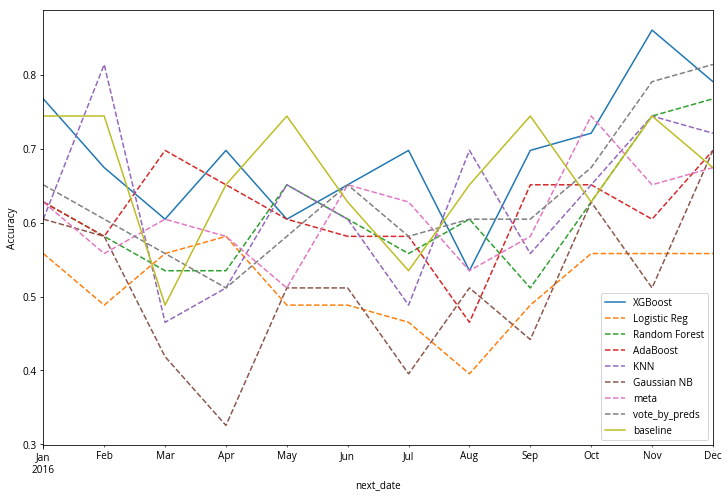

In [15]:
testing_results_df['baseline'] = (truth == 0).astype(int)

for name in testing_history.keys():
    testing_results_df.loc[:,name] = testing_results_df[name].astype(int)

testing_results_df['XGBoost'].astype(int)
testing_results_df['XGBoost']

grouped = testing_results_df.groupby(pd.to_datetime(testing_results_df['next_date'])).mean()


# Plot the results
plt.figure(figsize=(12, 8))
for name in testing_history.keys():
    ls = '--'
    if name == 'XGBoost':
        ls = 'solid'
    grouped[name].plot(label=name, ls=ls)
    

grouped['baseline'].plot(label='baseline', ls='solid')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### XGBoost appears to be the best model, but does poorly where there is a drop in gun violence (indicated by baseline accuracy spikes).

## Cumulative Accuracy Profile
We plot the cumulative accuracy profile curve for our best model: XGBoost

In [16]:
def get_cap(model_name, year='2016'):
    # Get the probabilities from the testing history
    probs = testing_history_probs[model_name]

    # Create a DataFrame to keep track of the CAP, and split by month
    all_cap_df = pd.DataFrame(truth)
    all_cap_df['probs'] = probs
    cap_splits = np.split(all_cap_df, 12)

    # Get month names, length of each split, and the halfway point 
    months = calendar.month_name[1:]
    split_length = cap_splits[0].shape[0]
    split_range = np.arange(split_length) / split_length
    halfway_point = split_length // 2

    # Plot the CAP in a 4x3 subplot 
    plt.figure(figsize=(15, 10))
    for i, cap_df in enumerate(cap_splits):
        # Calculate CAP
        cap_df = cap_df.sort_values('probs')
        cap_df['cap'] = cap_df['label'].cumsum() / cap_df['label'].sum()

        # Plot
        plt.subplot(4, 3, i + 1)
        plt.plot(split_range, cap_df['cap'], ls='-')

        # Show halfway point and label with the lift
        cap_half = cap_df.iloc[halfway_point]['cap']
        plt.annotate("50%: {:.2f}".format(cap_half), xy=(0.55, 0.1))
        plt.plot([0.5, 0.5], [0,1], ls='--')
        plt.title(months[i])

    # Show plots
    plt.subplots_adjust(top=0.90, hspace=0.5) # Space out the plots a bit more vertically
    plt.suptitle('{} Cumulative Accuracy Profile for {} Predictions'
                 .format(model_name, year), fontsize=18)
    plt.show()

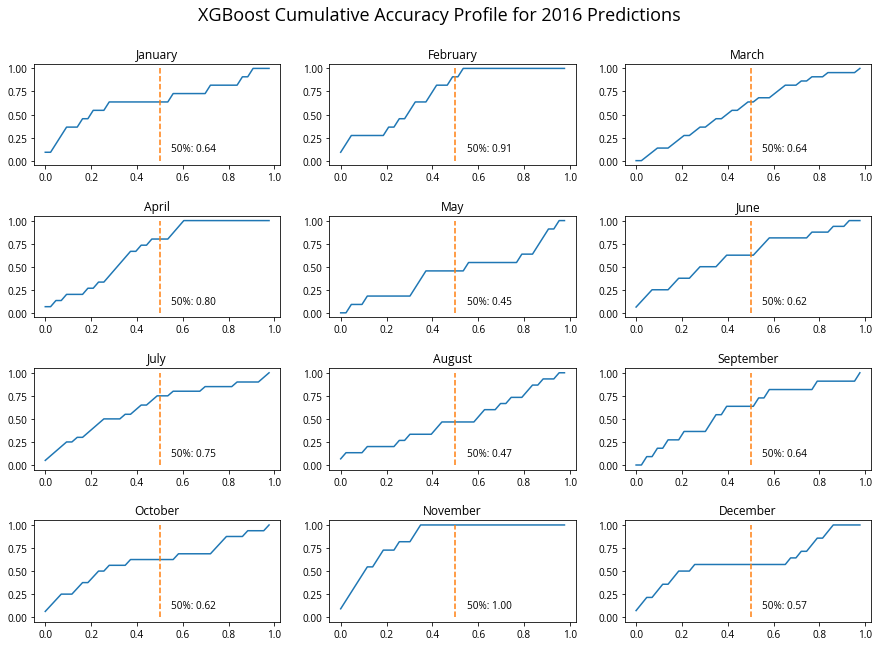

In [17]:
get_cap('XGBoost')

## The model seems to do particularily poorly during May and August. From the visualization, we can note that these months had dips in gun violence rates, which may account for the poor accuracy in the modeling.

# Using the full training set

We now train the model on the **entire training set (from 2014-2016)** with the best models from the spot-checking. These will be
```
XGBoost
Logistic Regression
AdaBoost
```
We will use these models to **make predictions for the year 2017.**

In [18]:
# Reset the feautre_df predictions
# Make placeholders for two additional features: one for predictions of this month, and one for next month
feature_df['this_preds'] = 0
feature_df['next_preds'] = 0

start = np.where(dates == '2017-01-31')[0][0]
end = dates.shape[0]

models = {
    'XGBoost': (XGBClassifier(), xgb_params), 
    'Logistic Reg': (LogisticRegression(), logi_regr_params),
    'AdaBoost': (AdaBoostClassifier(), adaboost_params),
}

(training_history, testing_history, 
testing_history_probs, trained_models) = train_models(feature_df, models, resampled_df,
                                                     dates, start, end, extra_columns)



Updating trends for with this_date 2016-12-31...
Training XGBoost | next_date: 2017-01-31... 
Training Logistic Reg | next_date: 2017-01-31... 
Training AdaBoost | next_date: 2017-01-31... 
Training XGBoost | next_date: 2017-01-31... 
Training Logistic Reg | next_date: 2017-01-31... 
Training AdaBoost | next_date: 2017-01-31... 
Training XGBoost | next_date: 2017-01-31... 
Training Logistic Reg | next_date: 2017-01-31... 
Training AdaBoost | next_date: 2017-01-31... 
Training XGBoost | next_date: 2017-01-31... 
Training Logistic Reg | next_date: 2017-01-31... 
Training AdaBoost | next_date: 2017-01-31... 
Training XGBoost | next_date: 2017-01-31... 
Training Logistic Reg | next_date: 2017-01-31... 
Training AdaBoost | next_date: 2017-01-31... 
Training XGBoost | next_date: 2017-01-31... 
Training Logistic Reg | next_date: 2017-01-31... 
Training AdaBoost | next_date: 2017-01-31... 
Training XGBoost | next_date: 2017-01-31... 
Training Logistic Reg | next_date: 2017-01-31... 
Training A

Training AdaBoost | next_date: 2017-02-28... 
Training XGBoost | next_date: 2017-02-28... 
Training Logistic Reg | next_date: 2017-02-28... 
Training AdaBoost | next_date: 2017-02-28... 
Training XGBoost | next_date: 2017-02-28... 
Training Logistic Reg | next_date: 2017-02-28... 
Training AdaBoost | next_date: 2017-02-28... 
Training XGBoost | next_date: 2017-02-28... 
Training Logistic Reg | next_date: 2017-02-28... 
Training AdaBoost | next_date: 2017-02-28... 
Training XGBoost | next_date: 2017-02-28... 
Training Logistic Reg | next_date: 2017-02-28... 
Training AdaBoost | next_date: 2017-02-28... 
Training XGBoost | next_date: 2017-02-28... 
Training Logistic Reg | next_date: 2017-02-28... 
Training AdaBoost | next_date: 2017-02-28... 
Training XGBoost | next_date: 2017-02-28... 
Training Logistic Reg | next_date: 2017-02-28... 
Training AdaBoost | next_date: 2017-02-28... 
Training XGBoost | next_date: 2017-02-28... 
Training Logistic Reg | next_date: 2017-02-28... 
Training AdaB

Training AdaBoost | next_date: 2017-03-31... 
Training XGBoost | next_date: 2017-03-31... 
Training Logistic Reg | next_date: 2017-03-31... 
Training AdaBoost | next_date: 2017-03-31... 
Training XGBoost | next_date: 2017-03-31... 
Training Logistic Reg | next_date: 2017-03-31... 
Training AdaBoost | next_date: 2017-03-31... 
Training XGBoost | next_date: 2017-03-31... 
Training Logistic Reg | next_date: 2017-03-31... 
Training AdaBoost | next_date: 2017-03-31... 
Training XGBoost | next_date: 2017-03-31... 
Training Logistic Reg | next_date: 2017-03-31... 
Training AdaBoost | next_date: 2017-03-31... 
Training XGBoost | next_date: 2017-03-31... 
Training Logistic Reg | next_date: 2017-03-31... 
Training AdaBoost | next_date: 2017-03-31... 
Training XGBoost | next_date: 2017-03-31... 
Training Logistic Reg | next_date: 2017-03-31... 
Training AdaBoost | next_date: 2017-03-31... 
Training XGBoost | next_date: 2017-03-31... 
Training Logistic Reg | next_date: 2017-03-31... 
Training AdaB

Training Logistic Reg | next_date: 2017-05-31... 
Training AdaBoost | next_date: 2017-05-31... 
Training XGBoost | next_date: 2017-05-31... 
Training Logistic Reg | next_date: 2017-05-31... 
Training AdaBoost | next_date: 2017-05-31... 
Training XGBoost | next_date: 2017-05-31... 
Training Logistic Reg | next_date: 2017-05-31... 
Training AdaBoost | next_date: 2017-05-31... 
Training XGBoost | next_date: 2017-05-31... 
Training Logistic Reg | next_date: 2017-05-31... 
Training AdaBoost | next_date: 2017-05-31... 
Training XGBoost | next_date: 2017-05-31... 
Training Logistic Reg | next_date: 2017-05-31... 
Training AdaBoost | next_date: 2017-05-31... 
Training XGBoost | next_date: 2017-05-31... 
Training Logistic Reg | next_date: 2017-05-31... 
Training AdaBoost | next_date: 2017-05-31... 
Training XGBoost | next_date: 2017-05-31... 
Training Logistic Reg | next_date: 2017-05-31... 
Training AdaBoost | next_date: 2017-05-31... 
Training XGBoost | next_date: 2017-05-31... 
Training Logi

Training Logistic Reg | next_date: 2017-06-30... 
Training AdaBoost | next_date: 2017-06-30... 
Training XGBoost | next_date: 2017-06-30... 
Training Logistic Reg | next_date: 2017-06-30... 
Training AdaBoost | next_date: 2017-06-30... 
Training XGBoost | next_date: 2017-06-30... 
Training Logistic Reg | next_date: 2017-06-30... 
Training AdaBoost | next_date: 2017-06-30... 
Training XGBoost | next_date: 2017-06-30... 
Training Logistic Reg | next_date: 2017-06-30... 
Training AdaBoost | next_date: 2017-06-30... 
Training XGBoost | next_date: 2017-06-30... 
Training Logistic Reg | next_date: 2017-06-30... 
Training AdaBoost | next_date: 2017-06-30... 
Training XGBoost | next_date: 2017-06-30... 
Training Logistic Reg | next_date: 2017-06-30... 
Training AdaBoost | next_date: 2017-06-30... 
Training XGBoost | next_date: 2017-06-30... 
Training Logistic Reg | next_date: 2017-06-30... 
Training AdaBoost | next_date: 2017-06-30... 
Training XGBoost | next_date: 2017-06-30... 
Training Logi

Training Logistic Reg | next_date: 2017-07-31... 
Training AdaBoost | next_date: 2017-07-31... 
Training XGBoost | next_date: 2017-07-31... 
Training Logistic Reg | next_date: 2017-07-31... 
Training AdaBoost | next_date: 2017-07-31... 
Training XGBoost | next_date: 2017-07-31... 
Training Logistic Reg | next_date: 2017-07-31... 
Training AdaBoost | next_date: 2017-07-31... 
Training XGBoost | next_date: 2017-07-31... 
Training Logistic Reg | next_date: 2017-07-31... 
Training AdaBoost | next_date: 2017-07-31... 
Training XGBoost | next_date: 2017-07-31... 
Training Logistic Reg | next_date: 2017-07-31... 
Training AdaBoost | next_date: 2017-07-31... 
Training XGBoost | next_date: 2017-07-31... 
Training Logistic Reg | next_date: 2017-07-31... 
Training AdaBoost | next_date: 2017-07-31... 
Training XGBoost | next_date: 2017-07-31... 
Training Logistic Reg | next_date: 2017-07-31... 
Training AdaBoost | next_date: 2017-07-31... 
Training XGBoost | next_date: 2017-07-31... 
Training Logi

Training XGBoost | next_date: 2017-09-30... 
Training Logistic Reg | next_date: 2017-09-30... 
Training AdaBoost | next_date: 2017-09-30... 
Training XGBoost | next_date: 2017-09-30... 
Training Logistic Reg | next_date: 2017-09-30... 
Training AdaBoost | next_date: 2017-09-30... 
Training XGBoost | next_date: 2017-09-30... 
Training Logistic Reg | next_date: 2017-09-30... 
Training AdaBoost | next_date: 2017-09-30... 
Training XGBoost | next_date: 2017-09-30... 
Training Logistic Reg | next_date: 2017-09-30... 
Training AdaBoost | next_date: 2017-09-30... 
Training XGBoost | next_date: 2017-09-30... 
Training Logistic Reg | next_date: 2017-09-30... 
Training AdaBoost | next_date: 2017-09-30... 
Training XGBoost | next_date: 2017-09-30... 
Training Logistic Reg | next_date: 2017-09-30... 
Training AdaBoost | next_date: 2017-09-30... 
Training XGBoost | next_date: 2017-09-30... 
Training Logistic Reg | next_date: 2017-09-30... 
Training AdaBoost | next_date: 2017-09-30... 
Training XGBo

Training XGBoost | next_date: 2017-10-31... 
Training Logistic Reg | next_date: 2017-10-31... 
Training AdaBoost | next_date: 2017-10-31... 
Training XGBoost | next_date: 2017-10-31... 
Training Logistic Reg | next_date: 2017-10-31... 
Training AdaBoost | next_date: 2017-10-31... 
Training XGBoost | next_date: 2017-10-31... 
Training Logistic Reg | next_date: 2017-10-31... 
Training AdaBoost | next_date: 2017-10-31... 
Training XGBoost | next_date: 2017-10-31... 
Training Logistic Reg | next_date: 2017-10-31... 
Training AdaBoost | next_date: 2017-10-31... 
Training XGBoost | next_date: 2017-10-31... 
Training Logistic Reg | next_date: 2017-10-31... 
Training AdaBoost | next_date: 2017-10-31... 
Training XGBoost | next_date: 2017-10-31... 
Training Logistic Reg | next_date: 2017-10-31... 
Training AdaBoost | next_date: 2017-10-31... 
Training XGBoost | next_date: 2017-10-31... 
Training Logistic Reg | next_date: 2017-10-31... 
Training AdaBoost | next_date: 2017-10-31... 
Training XGBo

Training XGBoost | next_date: 2017-11-30... 
Training Logistic Reg | next_date: 2017-11-30... 
Training AdaBoost | next_date: 2017-11-30... 
Training XGBoost | next_date: 2017-11-30... 
Training Logistic Reg | next_date: 2017-11-30... 
Training AdaBoost | next_date: 2017-11-30... 
Training XGBoost | next_date: 2017-11-30... 
Training Logistic Reg | next_date: 2017-11-30... 
Training AdaBoost | next_date: 2017-11-30... 
Training XGBoost | next_date: 2017-11-30... 
Training Logistic Reg | next_date: 2017-11-30... 
Training AdaBoost | next_date: 2017-11-30... 
Training XGBoost | next_date: 2017-11-30... 
Training Logistic Reg | next_date: 2017-11-30... 
Training AdaBoost | next_date: 2017-11-30... 
Training XGBoost | next_date: 2017-11-30... 
Training Logistic Reg | next_date: 2017-11-30... 
Training AdaBoost | next_date: 2017-11-30... 
Training XGBoost | next_date: 2017-11-30... 
Training Logistic Reg | next_date: 2017-11-30... 
Training AdaBoost | next_date: 2017-11-30... 
Training XGBo

In [19]:
all_preds = []
for v in testing_history.values():
    all_preds.append(v)
    
all_preds = np.array(all_preds).T
vote_by_preds = [int(x > 0.5) for x in all_preds.mean(axis=1)]

testing_history['vote_by_preds'] = vote_by_preds

In [20]:
date_filter = (feature_df['next_date'] >= '2017-01-31')
truth = feature_df.loc[date_filter, 'label']

testing_results_df = pd.DataFrame(feature_df.loc[date_filter, ['label', 'next_date']])
for name, preds in testing_history.items():
    # Add predictions to feature_df
    testing_results_df[name] = preds == truth
    
    # Get accuracy score and confusion matrix
    print("{}: {} ".format(name, accuracy_score(truth, preds)))
    cm = confusion_matrix(truth, preds)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
#     print("True Negative: {}".format(tn))
#     print("False Positive: {}".format(fp))
#     print("False Negative: {}".format(fn))
#     print("True Positive: {}".format(tp))
    print("Recall: {}**".format(recall))
    print("Precision: {}".format(precision))
    print(cm)
    print('-'*10)

XGBoost: 0.7558139534883721 
Recall: 0.6024844720496895**
Precision: 0.610062893081761
[[293  62]
 [ 64  97]]
----------
Logistic Reg: 0.563953488372093 
Recall: 0.6583850931677019**
Precision: 0.38405797101449274
[[185 170]
 [ 55 106]]
----------
AdaBoost: 0.6802325581395349 
Recall: 0.6086956521739131**
Precision: 0.49
[[253 102]
 [ 63  98]]
----------
meta: 0.689922480620155 
Recall: 0.5838509316770186**
Precision: 0.5026737967914439
[[262  93]
 [ 67  94]]
----------
vote_by_preds: 0.7267441860465116 
Recall: 0.5652173913043478**
Precision: 0.5617283950617284
[[284  71]
 [ 70  91]]
----------


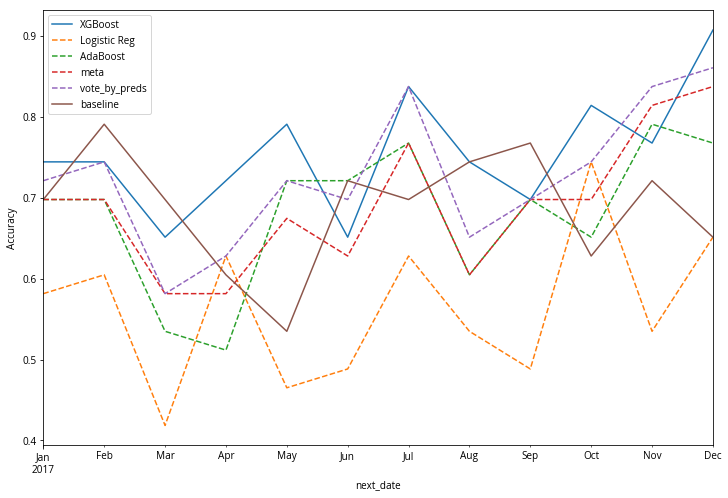

In [21]:
testing_results_df['baseline'] = (truth == 0).astype(int)

for name in testing_history.keys():
    testing_results_df.loc[:,name] = testing_results_df[name].astype(int)

testing_results_df['XGBoost'].astype(int)
testing_results_df['XGBoost']

grouped = testing_results_df.groupby(pd.to_datetime(testing_results_df['next_date'])).mean()


# Plot the results
plt.figure(figsize=(12, 8))
for name in testing_history.keys():
    ls = '--'
    if name == 'XGBoost':
        ls = 'solid'
    grouped[name].plot(label=name, ls=ls)
    

grouped['baseline'].plot(label='baseline', ls='solid')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

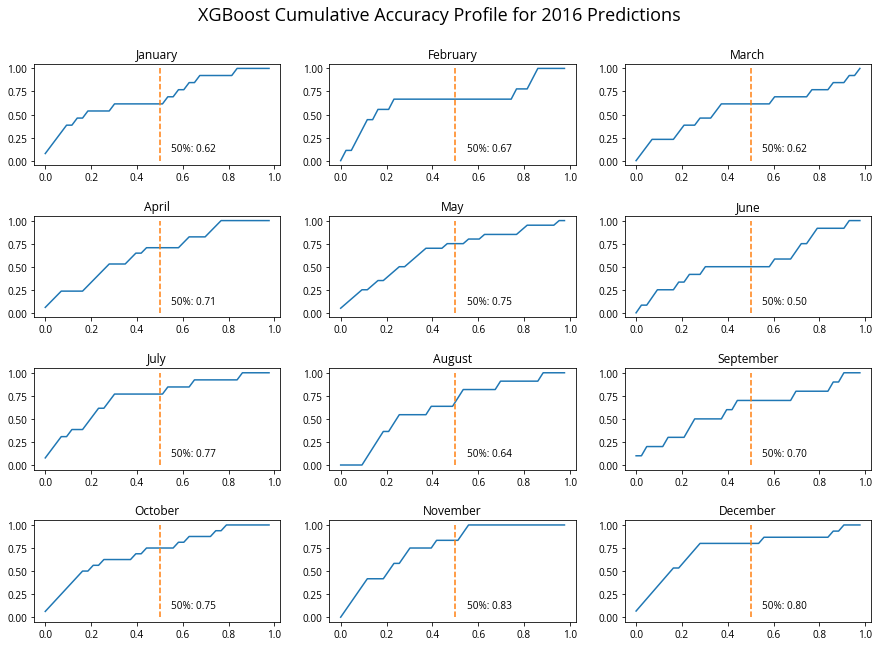

In [22]:
get_cap('XGBoost')

### Each model did better after adding one more year of training data, with accuracy improving by ~1-6%.
## The best model was XGBoost, which showed 75.5% accuracy on the training data and a 60% recall. 